# Modular RAG와 MCP

### 0. 학습 목표

- Modular RAG의 핵심 개념과 모듈 단위 설계 원리를 이해하고 설명할 수 있다.  
- LangGraph를 활용해 **Query → Retrieve → Rerank → Compress → Generate** 구조의  
  RAG 파이프라인을 직접 구성하고 수정할 수 있다.  
- MCP(Model Context Protocol)의 개념과 역할을 이해하고, LLM이 외부 API·DB·파일 시스템에 접근하도록 도구를 설계할 수 있다.  
- RAG와 MCP를 결합하여 **실시간 정보 + 사전 구축 문서**를 함께 처리하는 엔터프라이즈형 하이브리드 검색 시스템을 만들 수 있다.  
- Retrieval 실패·API 오류 등 실제 환경 문제에 대응하는 안전한 Fail-safe 구조를 설계할 수 있다.

## 1. Modular RAG

### 1.1 Modular RAG란 무엇인가?

전통적인 RAG(Retrieval-Augmented Generation)는 아래와 같은 **직렬(Sequential)** 구조를 사용합니다.

```
Query → Retrieve → Generate
```

이 구조는 단순하고 구현이 쉽지만,  
**한 번 정해진 흐름을 되돌리거나 분기하기 어려운 구조**라는 한계를 가집니다.

#### ① 전통적 RAG의 구조적 한계 (유연성 관점)

기존 RAG는 기본적으로 **“앞으로만 흐르는 파이프라인”** 입니다.

- Retrieval 결과가 부정확해도 다시 검색하거나 질문을 수정해 재시도하기 어려움  
- 중간 단계에서 문제가 발견되어도 이전 단계로 되돌아갈 수 없음  
- 모든 질문을 항상 동일한 처리 경로로만 실행  
- 예외 상황(검색 실패, 문서 과다, 오래된 문서 등)을 구조적으로 처리하기 어려움  

즉, 기존 RAG는  
> “한 번 던지고, 한 번 검색하고, 바로 답한다”  
라는 **단선적인 처리 방식**에 가깝습니다.

#### ② 실제 서비스 환경에서 필요한 RAG의 모습

실제 서비스 환경에서는 질문을 처리하는 도중  
다음과 같은 판단이 반복적으로 발생합니다.

- “검색 결과가 이상하다 → 질문을 다시 써서 재검색하자”
- “문서가 너무 많다 → 일부만 압축해서 사용하자”
- “정확도가 낮다 → 다른 검색 방식으로 다시 시도하자”
- “이 질문은 FAQ 파이프라인으로 보내는 게 낫다”
- “지금 상태로 답변하면 위험하다 → 이전 단계로 돌아가자”

즉, **실전 RAG는 한 방향 파이프라인이 아니라  판단 → 분기 → 재시도 → 복귀가 가능한 구조**여야 합니다.

#### ③ Modular RAG의 핵심 철학: 흐름을 고정하지 않는다

Modular RAG는 RAG 파이프라인을  
**항상 앞으로만 가는 구조가 아니라**,  
**상황에 따라 분기하고, 되돌아가고, 우회할 수 있는 흐름**으로 바라봅니다.

```
Query
 → Rewrite
 → Retrieve
 → (조건 판단)
      ├→ Rerank → Compress → Generate
      ├→ Rewrite → Retrieve (재시도)
      └→ Fallback Retrieval
```

- 각 단계는 독립된 모듈(Node)
- 필요 시 이전 단계로 되돌아갈 수 있음
- 조건에 따라 완전히 다른 경로로 분기 가능
- 실패를 전제로 설계된 구조

#### ④ Modular RAG의 기본 형태

Modular RAG는 전체 파이프라인을 다음과 같이 조립 가능한 구조로 바라봅니다.

```
Query
 → Rewrite
 → Retrieve
 → Rerank
 → Filter
 → Compress
 → Generate
 → Output
```

중요한 점은 이 순서가 **항상 고정된 것이 아니라는 점**입니다.

- 질문에 따라 Rewrite 단계를 생략할 수 있고
- Retrieve 이후 다시 Rewrite로 되돌아갈 수 있으며
- Generate 이전에 추가 검증 단계를 삽입할 수도 있습니다

이를 위해 각 단계를 **독립된 Node(모듈)** 로 분리합니다.

#### ✔ 예시 시나리오 (유연성이 왜 중요한가)

사용자가 다음과 같이 질문한다고 가정합니다.

> “2025년 농업기술 관련 정책 보고서를 요약해줘”

처리 과정에서 다음과 같은 판단이 발생할 수 있습니다.

1. 검색 결과에 2022~2023년 문서가 섞여 있음  
   → Retrieve 단계 재시도  
2. 문서 분량이 너무 길어 LLM 요약 품질 저하  
   → Compress 단계 추가  
3. 요약 신뢰도가 낮음  
   → 다른 Reranker로 분기  

이러한 판단은  
**사전에 고정된 파이프라인으로는 처리하기 어렵고**,  
**유연한 흐름 구조에서만 자연스럽게 처리**할 수 있습니다.

#### 요약

- 기존 RAG는 단순하지만 단선적인 구조를 가짐
- 실전 RAG는 되돌아감, 분기, 재시도가 필수
- Modular RAG는 파이프라인을 고정된 순서가 아닌 조립 가능한 흐름으로 설계
- 실패와 예외를 전제로 한 구조다

### 1.2 LangGraph 기본 개념

Modular RAG의 이러한 유연한 흐름을  
실제 코드 구조로 구현하기 위해 사용하는 도구가 **LangGraph**입니다.

LangGraph는 LLM 기반 워크플로우를  
**그래프(Graph)** 구조로 정의하는 프레임워크입니다.

#### ① Graph란 무엇인가? (개념 설명)

Graph는 어렵게 들릴 수 있지만,  
개념적으로는 **작업 흐름을 점과 선으로 표현한 지도**입니다.

- 점(Node): 하나의 작업
- 선(Edge): 다음으로 이동하는 흐름
- 갈림길: 조건에 따라 선택되는 경로

즉, Graph는  
**“어떤 작업을 한 뒤, 다음에 무엇을 할지”를 시각적으로 표현한 구조**입니다.

#### ② LangGraph의 핵심 구성 요소

LangGraph는 다음 세 가지 요소로 구성됩니다.

##### Node (노드)

- 하나의 기능을 수행하는 최소 단위
- 예: 질문 재작성, 문서 검색, 요약 생성

```
[Rewrite] → [Retrieve] → [Generate]
```

##### Edge (엣지)

- Node와 Node를 연결하는 실행 흐름
- 다음에 실행될 Node를 결정

```
Rewrite ──→ Retrieve
```

##### State (상태)

State는 그래프 전체에서 공유되는 **공용 데이터 공간**입니다.

```python
state = {
    "query": "...",
    "rewritten_query": "...",
    "docs": [...],
    "answer": "..."
}
```

- 모든 Node는 동일한 state를 입력으로 받음
- 필요한 값만 읽고
- 새로 생성한 값만 업데이트하여 반환

중요한 점은  
**Node가 state 전체를 덮어쓰지 않고, 일부 key만 수정한다는 것**입니다.

#### ③ 왜 Graph 구조가 중요한가?

Graph 구조이기 때문에 LangGraph에서는 다음이 가능합니다.

- 조건에 따른 분기 실행
- 이전 단계로의 재진입
- 특정 Node만 교체하여 실험 가능
- A/B 테스트 및 파이프라인 확장 용이

기존의 직렬 파이프라인에서는 이 모든 것이 복잡한 조건문으로 얽히게 됩니다.

#### ④ LangGraph는 “흐름을 설계하는 도구”

LangGraph는 단순히 LLM을 호출하는 라이브러리가 아니라,

> **LLM 기반 시스템의 실행 흐름 자체를 설계하는 도구**

입니다.

이 점에서 LangGraph는 Modular RAG의 설계 철학과 매우 높은 궁합을 가집니다.

#### 정리

- LangGraph는 RAG 파이프라인을 그래프 구조로 표현
- Node는 기능 단위, Edge는 실행 흐름
- State는 Node들이 공유하는 전역 데이터
- 분기, 되돌아감, 재시도 구조를 자연스럽게 구현 가능
- Modular RAG 설계를 코드로 가장 잘 구현할 수 있는 프레임워크

### 1.3 LangGraph 최소 동작 예제  
(State + Node 3개)

#### 1.3.1 최소 RAG 흐름 구조

본 예제에서는 다음과 같은 최소 RAG 흐름을 구현합니다.

```
Query
 → Rewrite
 → Retrieve
 → Generate
```

이 구조는 단순하지만, LangGraph의 핵심 요소인 **State, Node, Edge**를 모두 포함하며  
이후 단계 확장이 가능한 기본 골격입니다.

#### 1.3.2 State의 역할과 필요성

State는 그래프 전체에서 **공유되는 데이터 구조**입니다.

일반적인 함수 기반 파이프라인에서는 다음과 같은 문제가 발생합니다.

- 단계가 늘어날수록 함수 인자가 복잡해집니다.
- 중간 결과를 어디에서 관리하는지 파악하기 어렵습니다.
- 파이프라인 수정 시 여러 함수에 영향을 줍니다.

LangGraph에서는 이를 다음과 같이 해결합니다.

- 모든 중간 결과를 하나의 State에 저장합니다.
- 각 Node는 필요한 값만 읽습니다.
- 각 Node는 새로 생성한 값만 State에 추가합니다.

즉, State는 **흐름을 따라 이동하며 누적되는 공용 데이터 공간**입니다.

#### 1.3.3 State 정의
    
설명:
- 초기 입력 시에는 `query`만 존재합니다.
- Node를 통과하면서 State의 필드가 점진적으로 채워집니다.
- State는 고정된 결과물이 아니라 **처리 과정 중 변화하는 구조**입니다.

In [1]:
from typing import TypedDict, List

class RAGState(TypedDict):
    query: str
    rewritten_query: str
    docs: List[str]
    answer: str

#### 1.3.4 Node ① Query Rewrite Node

이 Node는 사용자의 질문을 검색에 적합한 형태로 정제하는 역할을 수행합니다.

중요한 특징은 다음과 같습니다.

- Node는 State 전체를 반환하지 않습니다.
- 자신이 생성한 결과만 dict 형태로 반환합니다.
- LangGraph가 이를 기존 State에 병합합니다.

In [2]:
def rewrite_node(state: RAGState):
    """
    - 입력: state["query"]
    - 출력: state["rewritten_query"]

    실제 환경에서는 LLM을 사용하지만,
    본 예제에서는 구조 이해를 위해 단순 문자열 처리로 대체합니다.
    """
    rewritten = f"{state['query']} (정책 보고서 기준)"
    
    return {
        "rewritten_query": rewritten
    }

#### 1.3.5 Node ② Retrieve Node

이 Node는 정제된 질문을 기반으로 문서를 검색하는 역할만 수행합니다.

설명:
- 이 Node는 답변을 생성하지 않습니다.
- 검색과 생성 단계를 분리하는 것이 Modular RAG의 핵심입니다.

In [3]:
def retrieve_node(state: RAGState):
    """
    - 입력: state["rewritten_query"]
    - 출력: state["docs"]

    실제 서비스에서는 Vector DB 또는 검색 엔진이 사용됩니다.
    """
    docs = [
        "2025년 농업기술 정책 보고서 요약본",
        "2024년 농업 R&D 투자 방향",
        "농업기술 혁신 전략 백서"
    ]
    
    return {
        "docs": docs
    }

#### 1.3.6 Node ③ Generate Node

이 Node는 검색된 문서를 바탕으로  
최종 답변을 생성합니다.

설명:
- Generate Node는 반드시 마지막 단계일 필요는 없습니다.
- 이후 검증, 출처 표기 등의 Node가 추가될 수 있습니다.

In [4]:
def generate_node(state: RAGState):
    """
    - 입력: state["docs"]
    - 출력: state["answer"]

    실제 환경에서는 LLM 호출이 이루어지는 위치입니다.
    """
    docs = state["docs"]
    
    answer = (
        f"총 {len(docs)}개의 문서를 기반으로 "
        "2025년 농업기술 정책을 요약했습니다."
    )
    
    return {
        "answer": answer
    }

#### 1.3.7 Graph 구성 (Node와 Edge 연결)

정의한 Node들을 그래프로 연결합니다.

설명:
- 실행 순서를 코드로 직접 호출하지 않습니다.
- Node 간의 **흐름 구조를 선언적으로 정의**합니다.
- Edge 변경만으로 전체 파이프라인을 수정할 수 있습니다.

In [5]:
from langgraph.graph import StateGraph

graph = StateGraph(RAGState)

graph.add_node("rewrite", rewrite_node)
graph.add_node("retrieve", retrieve_node)
graph.add_node("generate", generate_node)

graph.set_entry_point("rewrite")
graph.add_edge("rewrite", "retrieve")
graph.add_edge("retrieve", "generate")

app = graph.compile()

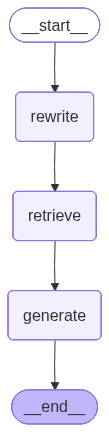

In [6]:
app

#### 1.3.8 실행 예제

In [7]:
initial_state = {
    "query": "2025년 농업기술 관련 정책 보고서를 요약해줘"
}

result = app.invoke(initial_state)

print(result["answer"])

총 3개의 문서를 기반으로 2025년 농업기술 정책을 요약했습니다.


In [8]:
for event in app.stream(initial_state):
    print(event)

{'rewrite': {'rewritten_query': '2025년 농업기술 관련 정책 보고서를 요약해줘 (정책 보고서 기준)'}}
{'retrieve': {'docs': ['2025년 농업기술 정책 보고서 요약본', '2024년 농업 R&D 투자 방향', '농업기술 혁신 전략 백서']}}
{'generate': {'answer': '총 3개의 문서를 기반으로 2025년 농업기술 정책을 요약했습니다.'}}


#### 1.3.9 정리

- LangGraph는 RAG 파이프라인을 Graph 구조로 표현합니다.
- State는 공유 데이터, Node는 기능 단위, Edge는 실행 흐름입니다.
- 최소 구조만으로도 Modular RAG의 기본 설계를 구현할 수 있습니다.
- 이후 조건 분기 및 고급 RAG 구조로 자연스럽게 확장 가능합니다.

### 1.4 조건 기반 Routing  
(State를 이용한 실행 분기)


#### 1.4.1 왜 Routing이 필요한가

실제 RAG 파이프라인에서는  
모든 질문을 동일한 흐름으로 처리하는 것이 적절하지 않은 경우가 많습니다.

예를 들면 다음과 같습니다.

- 검색된 문서가 너무 많은 경우
- 검색 결과가 비어 있는 경우
- 문서 길이가 지나치게 긴 경우
- 특정 유형의 질문인 경우

이러한 상황에서는 **조건에 따라 다른 Node로 분기하는 구조**가 필요합니다.

#### 1.4.2 LangGraph에서의 Routing 개념

LangGraph에서 Routing은  
**State의 값을 기준으로 다음에 실행할 Node를 결정하는 방식**입니다.

즉,

- if 문을 코드 곳곳에 흩뿌리는 것이 아니라
- **Graph의 흐름 자체를 조건적으로 설계**합니다.

Routing 판단은 보통 다음 기준을 사용합니다.

- State 안의 데이터 개수
- 특정 값의 존재 여부
- 점수 또는 길이 기준
- 이전 단계의 결과 상태

#### 1.4.3 Routing 판단 함수 정의

Routing을 위해 먼저 **판단 함수**를 정의합니다.

설명:
- 이 함수는 Node가 아닙니다.
- State를 읽어 **다음에 갈 경로 이름만 반환**합니다.
- LangGraph가 이 반환값을 기준으로 Edge를 선택합니다.

In [9]:
def should_compress(state: RAGState):
    """
    - docs 개수가 많으면 Compress Node로 이동
    - 그렇지 않으면 바로 Generate Node로 이동
    """
    if len(state["docs"]) > 2:
        return "compress"
    return "generate"

#### 1.4.4 Compress Node 추가

문서가 많은 경우를 대비해 간단한 Compress Node를 추가합니다.

설명:
- Compress Node는 새로운 필드를 만들지 않습니다.
- 기존 docs를 더 적합한 형태로 **재가공**합니다.

In [10]:
def compress_node(state: RAGState):
    """
    - 문서 수를 줄이거나 요약하는 단계
    - 실제 환경에서는 LLM 요약 또는 chunk 축약이 수행됩니다.
    """
    docs = state["docs"]
    
    compressed_docs = docs[:2]  # 예제에서는 앞 2개만 사용
    
    return {
        "docs": compressed_docs
    }

#### 1.4.5 Graph에 조건 분기 추가

이제 Graph에  
**조건 기반 Edge**를 추가합니다.

설명:
- retrieve 이후 흐름이 고정되지 않습니다.
- State 상태에 따라 실행 경로가 달라집니다.
- Graph 구조만 보고도 전체 흐름을 이해할 수 있습니다.

In [11]:
from langgraph.graph import StateGraph

graph = StateGraph(RAGState)

graph.add_node("rewrite", rewrite_node)
graph.add_node("retrieve", retrieve_node)
graph.add_node("compress", compress_node)
graph.add_node("generate", generate_node)

graph.set_entry_point("rewrite")

graph.add_edge("rewrite", "retrieve")

graph.add_conditional_edges(
    "retrieve",
    should_compress,
    {
        "compress": "compress",
        "generate": "generate"
    }
)

graph.add_edge("compress", "generate")

app = graph.compile()

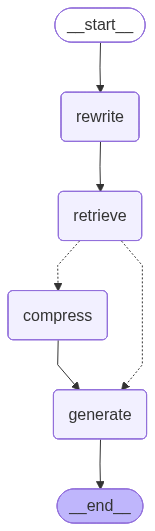

In [12]:
app

#### 1.4.6 실행 흐름 요약
```
Rewrite
 → Retrieve
      ├─ (docs 많음) → Compress → Generate
      └─ (docs 적음) → Generate
```

이 구조의 장점은 다음과 같습니다.

- 조건 판단 로직이 한 곳에 모입니다.
- Node 내부에 복잡한 if 문이 들어가지 않습니다.
- 파이프라인 확장이 매우 용이합니다.

#### 1.4.7 정리

- Routing은 State를 기준으로 실행 흐름을 분기하는 구조입니다.
- LangGraph는 조건 기반 Edge를 통해 이를 선언적으로 표현합니다.
- 이 방식은 복잡한 RAG 파이프라인을 깔끔하게 유지하는 데 핵심적인 역할을 합니다.
- 이후 Rerank, Fallback, 재시도 구조로 자연스럽게 확장 가능합니다.

### 1.5 실전 Routing 예제  
LangGraph는 Node 간 이동이 자유로운 구조이기 때문에  
설계에 따라 **의도하지 않은 무한 루프**가 발생할 수 있습니다.

대표적인 상황은 다음과 같습니다.

- 검색 결과가 부족하여 재검색을 반복하는 경우
- 질문을 Rewrite한 뒤 다시 Retrieve로 돌아가는 구조
- Fallback 경로가 다시 원래 경로로 연결된 경우

예시 구조:

```
Rewrite → Retrieve
   ↑         ↓
   └── (실패 시 재시도)
```

이 구조는 조건이 충족되지 않으면 **끝없이 같은 경로를 반복**할 수 있습니다.

#### 1.5.1 무한 루프 방지를 위한 기본 원칙

Graph 설계 시 다음 원칙을 반드시 적용해야 합니다.

1. **재시도 횟수를 State로 관리합니다**
2. **Routing 판단에 종료 조건을 포함합니다**
3. **되돌아가는 Edge는 항상 제한 조건과 함께 사용합니다**

즉, `언제 멈출 것인가`를 Graph 설계 단계에서 명시해야 합니다.

#### 1.5.2 목적 및 설계 조건

본 절에서는 다음 조건을 만족하는 Routing 구조를 구성합니다.

- **농업기술정책 관련 질문**이면 Vector DB를 우선 검색합니다.
- **그 외 질문**이면 Web Search를 사용합니다.
- 농업기술정책 질문이라도 Vector DB에서
  **유사도 임계값(threshold)을 만족하는 문서가 없으면 “검색 실패”로 간주**합니다.
- 검색 실패 시 **Rewrite → Vector 재검색을 재시도**합니다.
- 재시도 횟수 초과 시 **Web Search로 fallback**합니다.
- 무한 루프를 방지하기 위해 **retry_count를 State로 관리**합니다.


#### 1.5.3 State 확장 (재시도 제어 포함) 
- `retry_count`는 Vector 검색 실패 시 재시도 횟수를 제한하기 위해 사용합니다.
- 재시도 제한이 없으면 Graph에서 무한 루프가 발생할 수 있습니다.

In [13]:
from typing import TypedDict, List

class RAGState(TypedDict):
    query: str
    rewritten_query: str
    docs: List[str]
    answer: str
    retry_count: int

#### 1.5.4 LangChain Chat 모델 설정 (gpt-4o-mini)

- 분류 모델은 안정성을 위해 temperature=0으로 설정합니다.
- 생성 모델은 답변의 자연스러움을 위해 소폭의 temperature를 허용합니다.

In [14]:
from langchain_openai import ChatOpenAI

classifier_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

generator_llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.2
)

#### 1.5.5 질문 유형 판단: Web Search vs Vector DB

실전 환경에서는 모든 질문을 동일한 검색 방식으로 처리하는 것이 적절하지 않습니다.

본 예제에서는 다음 기준을 사용합니다.

- **농업기술정책 관련 질문** → Vector DB 검색  
- **그 외 일반 질문** → Web Search  

이 판단은 **LangChain 기반 LLM 분류 결과**를 사용하여 수행합니다.

#### 1.5.6 질문 분류용 Prompt 정의 (QUERY_CLASSIFICATION_PROMPT)
- 출력 형식을 엄격히 제한해야 Routing key로 안정적으로 사용할 수 있습니다.

In [20]:
QUERY_CLASSIFICATION_PROMPT = """
다음 사용자 질문이 '농업기술정책'과 직접적으로 관련된 질문인지 판단하십시오.

[분류 결과]
- vector: 농업기술정책 관련 질문인 경우
- web: 그 외 모든 질문인 경우

[vector로 분류해야 하는 예]
- 농업기술정책, 농업 R&D 정책, 정부 농업 기술 전략
- 농업 관련 공식 보고서, 계획, 제도, 정책 문서

질문:
{query}

반드시 아래 중 하나로만 답변하십시오.
vector
web
"""

#### 1.5.7 LLM 기반 Routing 판단 함수

- 이 함수는 Node가 아닙니다.
- State를 읽어 다음 실행 경로 이름만 반환합니다.
- LLM은 판단 전용으로 사용됩니다.

In [15]:
def route_by_query_type(state: RAGState):
    """
    - LangChain LLM을 사용하여 질문 유형을 분류합니다.
    - 반환값은 Graph 분기 key로 사용됩니다.
    """
    query = state["query"]

    prompt = QUERY_CLASSIFICATION_PROMPT.format(query=query)
    result = classifier_llm.invoke(prompt).content.strip().lower()

    if result not in ["vector", "web"]:
        # 예외 상황 대비 기본 경로
        return "web"

    return result

#### 1.5.8 Rewrite Node (재시도 카운터 포함)

- retry_count 증가는 “실패가 확인된 뒤”에 수행하는 편이 명확합니다.
- 따라서 본 예제에서는 실패 처리 Node에서 retry_count를 증가시킵니다.

In [16]:
def rewrite_node(state: RAGState):
    """
    - 검색에 유리하도록 질문을 구체화합니다.
    - Vector 검색 실패 시 재시도 루프에서 retry_count를 증가시킵니다.
    """
    query = state["query"]
    retry = state.get("retry_count", 0)

    rewritten = f"{query} (농업기술 정책/제도/보고서 기준으로 구체화)"

    return {
        "rewritten_query": rewritten,
        "retry_count": retry  # entry에서 0으로 시작하며, 실패 시 증가 로직은 별도 Node에서 수행합니다.
    }

#### 1.5.9 Vector DB 구성 및 Retriever 초기화 (직접 검색용)

- 농업기술정책 문서로 구축된 FAISS 인덱스가 존재한다고 가정합니다.
- 다른 Vector DB로 교체해도 Node 인터페이스는 동일하게 유지할 수 있습니다.

In [21]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()

vectorstore = FAISS.load_local(
    "my_faiss_index",
    embeddings,
    allow_dangerous_deserialization=True
)

#### 1.5.10 Vector DB 검색 Node (유사도 임계값 적용)

- threshold를 적용하지 않으면 관련 없는 문서가 포함되어 “성공처럼 보이는 실패”가 늘어납니다.
- docs가 빈 리스트이면 Vector 검색 실패로 간주합니다.

In [22]:
SIMILARITY_THRESHOLD = 0.75
TOP_K = 5

def vector_retrieve_node(state: RAGState):
    """
    - Vector DB에서 문서를 검색합니다.
    - 유사도 임계값을 만족하는 문서만 채택합니다.
    - 임계값을 만족하는 문서가 없으면 docs는 빈 리스트가 됩니다(=실패).
    """
    query = state["rewritten_query"]

    results = vectorstore.similarity_search_with_score(query, k=TOP_K)

    filtered_docs = [
        doc.page_content
        for doc, score in results
        if score >= SIMILARITY_THRESHOLD
    ]

    return {"docs": filtered_docs}

#### 1.5.11 Web Search Node (LangChain Tool)

- 실제 환경에서는 SerpAPI, Bing, Custom Search 등으로 교체할 수 있습니다.
- 본 실습에서는 **Tavily Search**를 사용합니다.

> **Tavily란?**
> - **LLM(AI)을 위해 최적화된 검색 엔진**입니다.
> - 일반 검색 엔진과 달리 광고나 불필요한 HTML 구조를 제거하고, AI가 답변 생성에 바로 사용할 수 있는 **깔끔한 텍스트 데이터**를 반환합니다.

**사전 준비: Tavily API Key 발급 (무료)**
1. [Tavily 공식 홈페이지(tavily.com)](https://tavily.com/)에 접속하여 회원가입합니다.
2. 로그인 후 대시보드(Overview)에서 `tvly-`로 시작하는 **API Key**를 복사합니다.

[필수] Tavily API Key 설정  
발급받은 키를 아래 .env 파일에 "TAVILY_API_KEY" 변수명으로 저장해주세요.

```bash
TAVILY_API_KEY = "tvly-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"
```

In [27]:
from langchain_community.tools import TavilySearchResults

# 검색 도구 초기화 (k=5: 검색 결과 상위 5개 가져오기)
web_search = TavilySearchResults(k=5)

def web_search_node(state: RAGState):
    """
    - 외부 공개 정보 및 최신 정보 검색에 사용합니다.
    - Tavily를 통해 검색하고, 내용(content)만 추출하여 반환합니다.
    """
    query = state["rewritten_query"]
    # 1. Tavily 검색 수행
    results = web_search.invoke(query)

    # 2. 결과에서 텍스트 내용만 추출
    docs = [r.get("content", "") for r in results if r.get("content")]
    return {"docs": docs}

#### 1.5.12 Vector 검색 실패 처리 Node (retry_count 증가)

In [29]:
def on_vector_failure_node(state: RAGState):
    """
    - Vector 검색 실패가 확인되었을 때 retry_count를 증가시킵니다.s
    - 이 Node는 실패 처리/제어 목적이며, 검색/생성과 책임을 분리합니다.
    """
    retry = state.get("retry_count", 0) + 1
    return {"retry_count": retry}

#### 1.5.13 재시도 / Fallback Routing 판단 함수

- 종료 조건(최대 재시도)을 명시하여 무한 루프를 방지합니다.

In [30]:
MAX_RETRIES = 2

def route_after_vector_search(state: RAGState):
    """
    Vector 검색 결과(docs)가 비어있으면 실패입니다.
    - retry_count < MAX_RETRIES 이면 rewrite로 되돌아가 재시도합니다.
    - retry_count >= MAX_RETRIES 이면 web_search로 fallback합니다.
    - docs가 있으면 generate로 진행합니다.
    """
    if len(state["docs"]) > 0:
        return "generate"

    if state.get("retry_count", 0) < MAX_RETRIES:
        return "retry"

    return "fallback_web"


#### 1.5.14 Generate Node (최소 예시)

In [31]:

def generate_node(state: RAGState):
    """
    - 검색된 docs를 기반으로 답변을 생성합니다.
    - 실제 환경에서는 prompt 템플릿 + 컨텍스트 구성 로직이 추가됩니다.
    """
    query = state["query"]
    docs = state["docs"]

    context = "\n\n".join(docs[:3])

    prompt = f"""
질문: {query}

아래 참고자료를 기반으로 간단히 요약하여 답변하십시오.
[참고자료]
{context}
""".strip()

    answer = generator_llm.invoke(prompt).content.strip()
    return {"answer": answer}

#### 1.5.15 Graph 연결 (Routing + 재시도 + Fallback)

- Vector 검색 실패 시 `on_vector_failure`에서 retry_count가 증가합니다.
- `route_after_vector_search`가 재시도 한계를 강제합니다.
- 재시도 실패 시 Web Search로 fallback하여 응답을 생성합니다.

In [32]:
from langgraph.graph import StateGraph

graph = StateGraph(RAGState)

# Node 등록
graph.add_node("rewrite", rewrite_node)
graph.add_node("vector_retrieve", vector_retrieve_node)
graph.add_node("web_search", web_search_node)
graph.add_node("on_vector_failure", on_vector_failure_node)
graph.add_node("generate", generate_node)

# 시작점
graph.set_entry_point("rewrite")

# 1) rewrite 이후 질문 유형 분기
graph.add_conditional_edges(
    "rewrite",
    route_by_query_type,
    {
        "vector": "vector_retrieve",
        "web": "web_search"
    }
)

# 2) vector_retrieve 이후: 성공이면 generate, 실패이면 실패처리로 이동
def vector_success_or_fail(state: RAGState):
    return "success" if len(state["docs"]) > 0 else "fail"

graph.add_conditional_edges(
    "vector_retrieve",
    vector_success_or_fail,
    {
        "success": "generate",
        "fail": "on_vector_failure"
    }
)

# 3) 실패 처리 후: 재시도 or web fallback or generate
graph.add_conditional_edges(
    "on_vector_failure",
    route_after_vector_search,
    {
        "retry": "rewrite",
        "fallback_web": "web_search",
        "generate": "generate"
    }
)

# 4) web_search는 generate로 연결
graph.add_edge("web_search", "generate")

app = graph.compile()

#### 1.5.16 실행 예시

In [33]:
initial_state = {
    "query": "2025년 농업기술정책 보고서 핵심만 요약해줘",
    "retry_count": 0
}

result = app.invoke(initial_state)

print("retry_count:", result.get("retry_count"))
print("answer:", result.get("answer"))

retry_count: 0
answer: 2025년 농업기술정책 보고서의 핵심 내용은 다음과 같습니다:

1. **호흡기 건강과 농업 기술**: '숨들'이라는 잎들깨 품종이 국민의 호흡기 건강을 지키는 데 기여할 것으로 기대됨.

2. **국산 폴리올레핀 필름**: 온실용 국산 폴리올레핀 필름의 만족도가 높아 수입 대체 효과가 기대됨.

3. **고추 유전자원 연구**: 고추는 한국 식탁에서 중요한 채소로, 풋마름병과 바이러스 병으로 인한 피해가 심각함. 이를 극복하기 위해 국립농업과학원에서 약 7천 개의 고추 유전자원을 연구하여 다양한 병에 저항성을 가진 품종을 발굴함.

4. **탄저병 저항성 고추**: 최근 연구를 통해 탄저병에 저항성을 가진 고추 유전자원을 선발하고, 이를 식물특허로 출원함. 이 품종은 기존의 저항성 품종과는 다른 유전적 배경을 가지고 있어 더욱 강력한 저항성을 보임.

이 보고서는 농업 기술의 발전을 통해 농민과 소비자에게 긍정적인 영향을 미칠 수 있는 다양한 연구 결과를 제시하고 있습니다.


#### 1.5.17 흐름 요약

- Rewrite → (LLM 분류)
  - vector:
    - Vector 검색(임계값 적용)
      - 성공: Generate
      - 실패: retry_count 증가 → 재시도(최대 2회) → 실패 시 Web fallback → Generate
  - web:
    - Web Search → Generate

#### 1.5.18 정리

- LLM 분류는 검색 전략을 결정하는 판단 단계입니다.
- Vector 검색은 유사도 임계값으로 품질을 보장해야 합니다.
- Vector 검색 실패는 재시도 가능성이 높으므로 rewrite 재시도를 포함해야 합니다.
- 재시도는 반드시 횟수 제한을 두어 무한 루프를 방지해야 합니다.
- 재시도 초과 시 Web Search로 fallback하는 경로를 명확히 두어야 합니다.